In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from collections import OrderedDict
from PIL import Image
import matplotlib.patches as patches
import keras
from sklearn.model_selection import train_test_split
import shutil
from shutil import unpack_archive
from subprocess import check_output
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, AveragePooling2D
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.python.keras import regularizers 

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.applications.vgg16 import preprocess_input
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn import metrics 
from pylab import rcParams
#from sklearn.datasets import make_moons
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from sklearn.decomposition import TruncatedSVD

data_directory = "/content/drive/MyDrive/Datasets/lwf_archive/lfw_funneled/"

In [2]:
def directory_mover(data, dir_name): #function that move directory from another directory
  co = 0
  for image in data.image_path:
        # create top directory
        if not os.path.exists(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name))
        
        data_type = data[data['image_path'] == image]['name']
        data_type = str(list(data_type)[0])
        if not os.path.exists(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name,data_type)):
            shutil.os.mkdir(os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name,data_type))
        path_from = os.path.join(data_directory, image)
        path_to = os.path.join('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/',dir_name,data_type)
        # print(path_to)
        shutil.copy(path_from, path_to)
        # print('Moved {} to {}'.format(image,path_to))
        co += 1
        
  print('Moved {} images to {} folder.'.format(co,dir_name))

In [3]:
lfw_allnames_data = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/lfw_allnames.csv")
matchpairsDevTestData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/matchpairsDevTest.csv")
matchpairDevTrainData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/matchpairsDevTrain.csv")
mismatchpairDevTestData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/mismatchpairsDevTest.csv")
mismatchpairDevTrainData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/mismatchpairsDevTrain.csv")
pairs = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/pairs.csv")

pairs = pairs.rename(columns={'name': 'name1', 'Unnamed: 3': 'name2'})
matched_pairs = pairs[pairs['name2'].isnull()].drop("name2", axis=1)
mismatchedpairs = pairs[pairs['name2'].notnull()]
people = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/people.csv")

people = people[people.name.notnull()]
peopleDevTestData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/peopleDevTest.csv")
peopleDevTrainData = pd.read_csv("/content/drive/MyDrive/Datasets/lfw_csv/peopleDevTrain.csv")

In [ ]:
print("Summary of LFW Data set")
print("Bu LFW veri setinde " + 
        str(lfw_allnames_data.shape[0]) + 
      " ünlü kişinin resmi bulunmaktadır " +
      str(sum(lfw_allnames_data.images > 1)) + 
      " adeti birden fazla resimle temsil edilmektedir. Tüm veri setinin görüntü sayısı " +
      str(sum(lfw_allnames_data.images)) + 
      " En çok temsil edilen ünlü " + 
      str(lfw_allnames_data.iloc[lfw_allnames_data['images'].idxmax()][0]) +
      " , nün görüntü sayısı " +
      str(max(lfw_allnames_data.images))
      )

Summary of LFW Data set
Bu LFW veri setinde 5749 ünlü kişinin resmi bulunmaktadır 1680 adeti birden fazla resimle temsil edilmektedir. Tüm veri setinin görüntü sayısı 13233 En çok temsil edilen ünlü George_W_Bush , nün görüntü sayısı 530


In [4]:
#shape the data set
image_paths = lfw_allnames_data.loc[lfw_allnames_data.index.repeat(lfw_allnames_data['images'])]
image_paths['image_path'] = 1 + image_paths.groupby('name').cumcount()
image_paths['image_path'] = image_paths.image_path.apply(lambda x: '{0:0>4}'.format(x))
image_paths['image_path'] = image_paths.name + "/" + image_paths.name + "_" + image_paths.image_path + ".jpg"
image_paths = image_paths.drop("images", 1)

lfw_train_data, lfw_test_data = train_test_split(image_paths, test_size=0.2) #test data - train data
lfw_train_data = lfw_train_data.reset_index().drop("index", 1) #drop the index 1
lfw_test_data = lfw_test_data.reset_index().drop("index", 1) #drop the index 2

print(len(set(lfw_train_data.name).intersection(set(lfw_test_data.name))))
print(len(set(lfw_test_data.name) - set(lfw_train_data.name)))


872
866


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  if __name__ == '__main__':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  # Remove the CWD from sys.path while we load stuff.


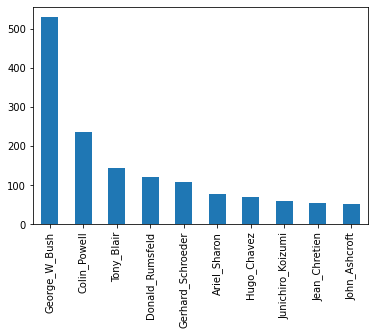

In [ ]:
image_paths['name'].value_counts()[:10].plot(kind = "bar") #ünlü şahıs dağılımı 

In [ ]:
#we use most prevail ones

image_paths["name"].value_counts()[:6]

George_W_Bush        530
Colin_Powell         236
Tony_Blair           144
Donald_Rumsfeld      121
Gerhard_Schroeder    109
Ariel_Sharon          77
Name: name, dtype: int64

In [5]:
multi_data_direct = pd.concat([image_paths[image_paths.name=="George_W_Bush"].sample(75),
                      image_paths[image_paths.name=="Colin_Powell"].sample(75),
                      image_paths[image_paths.name=="Tony_Blair"].sample(75),
                      image_paths[image_paths.name=="Donald_Rumsfeld"].sample(75),
                      image_paths[image_paths.name=="Gerhard_Schroeder"].sample(75),
                      image_paths[image_paths.name=="Ariel_Sharon"].sample(75)])

In [6]:
from keras.layers.core.dropout import Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization 
multi_train_data, multi_test_data = train_test_split(multi_data_direct, test_size=0.2)
multi_train_data, multi_vali_data = train_test_split(multi_train_data, test_size=0.2)

model_den = Sequential()
model_den.add(Conv2D(32, (3,3), input_shape=(110, 110, 3), activation='relu'))
model_den.add(MaxPooling2D(pool_size=(2,2)))
model_den.add(Flatten())
model_den.add(Dense(units=128, activation='relu'))
model_den.add(Dense(units=6, activation='softmax'))

In [7]:
model_den.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 108, 108, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 54, 54, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 93312)             0         
                                                                 
 dense (Dense)               (None, 128)               11944064  
                                                                 
 dense_1 (Dense)             (None, 6)                 774       
                                                                 
Total params: 11,945,734
Trainable params: 11,945,734
Non-trainable params: 0
____________________________________________

In [9]:
optimizer_den = SGD(learning_rate=0.01)
model_den.compile(optimizer=optimizer_den, loss='categorical_crossentropy', metrics=["accuracy"])

In [11]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, mode='max') #same callbacks
train_datagen_lfw = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2,
                                                                 horizontal_flip=True)
test_datagen_lfw = keras.preprocessing.image.ImageDataGenerator(rescale=1./255) 
multi_train_lfw = train_datagen_lfw.flow_from_directory('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/train_multi/',
                                                        target_size = (110, 110),
                                                        batch_size=32,
                                                        class_mode='categorical')
multi_val_lfw = test_datagen_lfw.flow_from_directory('/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/val_multi/',
                                                     target_size=(110, 110),
                                                     batch_size=32,
                                                     class_mode='categorical')
history_den = model_den.fit(multi_train_lfw, epochs=50, callbacks=[callback], validation_data=multi_val_lfw) #8 epoch denendi

Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Epoch 1/50
9/9 [==============================] - 3s 359ms/step - loss: 1.5064 - accuracy: 0.3750 - val_loss: 1.6692 - val_accuracy: 0.3611
Epoch 2/50
9/9 [==============================] - 3s 344ms/step - loss: 1.5047 - accuracy: 0.4132 - val_loss: 1.6192 - val_accuracy: 0.4306
Epoch 3/50
9/9 [==============================] - 3s 356ms/step - loss: 1.4470 - accuracy: 0.4340 - val_loss: 1.6147 - val_accuracy: 0.4167
Epoch 4/50
9/9 [==============================] - 3s 340ms/step - loss: 1.4182 - accuracy: 0.4479 - val_loss: 1.6130 - val_accuracy: 0.3889
Epoch 5/50
9/9 [==============================] - 4s 421ms/step - loss: 1.3879 - accuracy: 0.4688 - val_loss: 1.5608 - val_accuracy: 0.4306
Epoch 6/50
9/9 [==============================] - 3s 337ms/step - loss: 1.3693 - accuracy: 0.4757 - val_loss: 1.5394 - val_accuracy: 0.4444
Epoch 7/50
9/9 [==============================] - 3s 369ms/step - loss: 1.3533 

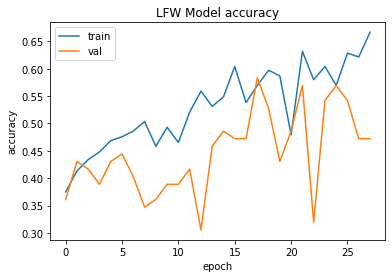

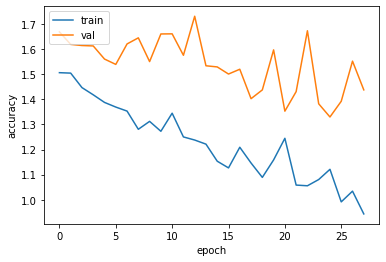

In [12]:
plt.plot(history_den.history['accuracy'])
plt.plot(history_den.history['val_accuracy'])
plt.title("LFW Model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_den.history['loss'])
plt.plot(history_den.history['val_loss'])
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left') 
plt.show()

In [14]:
#2 group version 2
path = r'/content/drive/MyDrive/Datasets/lwf_archive/lfw_sample2/'
num = -1

os.chdir(path)
faces_3 = []
y_train  = []

with os.scandir(path) as files:
  for file in files:
    num += 1
    name = file.name 
    if name.endswith('.txt'):
      num -= 1
      continue
    path_2 = os.path.join(path, name)
    os.chdir(path_2)
    with os.scandir(path_2) as files:
      for file2 in files:
        if file2.name.endswith('.jpg'):
          faces_3.append(file2)
          y_train.append(num)


<class 'posix.DirEntry'>
850
[<DirEntry 'Adriana_Perez_Navarro_0001.jpg'>, <DirEntry 'Agnes_Bruckner_0001.jpg'>, <DirEntry 'Adrianna_Zuzic_0001.jpg'>, <DirEntry 'Afton_Smith_0001.jpg'>, <DirEntry 'Adriana_Lima_0001.jpg'>, <DirEntry 'Alanis_Morissette_0001.jpg'>, <DirEntry 'Aileen_Riggin_Soule_0001.jpg'>, <DirEntry 'Aishwarya_Rai_0001.jpg'>, <DirEntry 'Aiysha_Smith_0001.jpg'>, <DirEntry 'Alberta_Lee_0001.jpg'>]


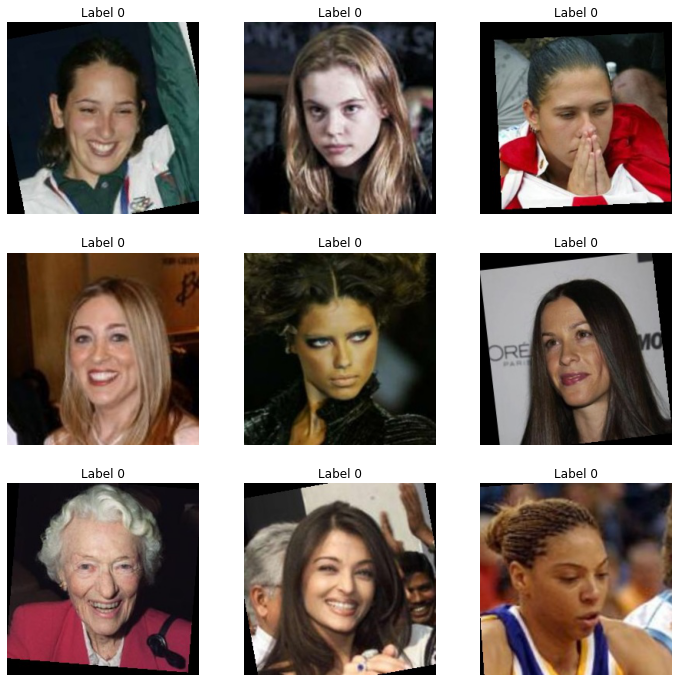

In [15]:
print(type(faces_3[0]))
print(len(faces_3))
print(faces_3[:10])

fig, axs = plt.subplots(3, 3, figsize = (12, 12))
for i, ax in enumerate(axs.flat):
  img = load_img(faces_3[i])
  img = np.array(img)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title('Label {}'.format(y_train[i]))

In [18]:
def CNN_face_den(file, model):
  img = load_img(file, target_size=(110, 110)) 
  img = np.array(img)  
  reshaped_image = img.reshape(1, 110, 110, 3)  
  imgx = preprocess_input(reshaped_image)  
  features = model.predict(imgx, use_multiprocessing=True) 
  return features 

In [19]:
from keras.models import Model
model_den_try = Model(inputs = model_den.inputs, outputs = model_den.layers[-2].output)
data_4 = {}

for face in faces_3:
  feat = CNN_face_den(face, model_den_try)
  data_4[face] = feat 

filenames = np.array(list(data_4.keys()))
feat = np.array(list(data_4.values()))
feat = feat.reshape(-1, 128)

In [20]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [21]:
kmeans_den = KMeans(n_clusters=2, random_state=22) 
kmeans_den.fit(x)

KMeans(n_clusters=2, random_state=22)

In [ ]:
from keras.layers.core.dropout import Dropout
from keras.layers.normalization.batch_normalization import BatchNormalization
multi_train_data, multi_test_data = train_test_split(multi_data_direct, test_size=0.2)
multi_train_data, multi_vali_data = train_test_split(multi_train_data, test_size=0.2)

model_lfw = Sequential()
model_lfw.add(Conv2D(32, (3,3), strides = 2, padding = "same", activation = 'relu', kernel_regularizer = regularizers.l2(l = 0.01), input_shape = (250, 250, 3)))
model_lfw.add(Conv2D(32, (3,3), strides = 2, padding = "same", activation = 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(BatchNormalization())
model_lfw.add(MaxPooling2D(pool_size = (3,3), strides = 2, padding = "same"))
#model_lfw.add(BatchNormalization())
model_lfw.add(Conv2D(64, (3,3), strides = 2, padding = "same", activation = 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(Conv2D(64, (3,3), strides = 2, padding = "same", activation= 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(BatchNormalization())
model_lfw.add(MaxPooling2D(pool_size = (3,3), strides = 2, padding = "same"))
model_lfw.add(Conv2D(64, (3,3), strides = 2, padding = "same", activation= 'relu', kernel_regularizer=regularizers.l2(l = 0.01)))
model_lfw.add(AveragePooling2D(pool_size = (2, 2), strides = (1, 1), padding = "same"))
model_lfw.add(Flatten())
model_lfw.add(Dense(units = 128, activation = 'relu'))
model_lfw.add(Dropout(0.5))
#model_lfw.add(Conv2D(32, (3,3), input_shape = (250, 250, 3), activation = 'relu'))
#model_lfw.add(MaxPooling2D(pool_size = (3,3)))
#model_lfw.add(Flatten())
#model_lfw.add(Dense(units = 128, activation='relu'))

model_lfw.add(Dense(units=6, activation='softmax'))


In [ ]:
model_lfw.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 125, 125, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 63, 63, 32)        9248      
                                                                 
 batch_normalization (BatchN  (None, 63, 63, 32)       128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 8, 8, 64)          3

In [ ]:
optimizer_2 = SGD(learning_rate=0.01, momentum = 0.99, nesterov = True, name = "SGD")
model_lfw.compile(optimizer=optimizer_2, loss="categorical_crossentropy", metrics=['accuracy'])

#directory_mover(multi_train_data, "train_multi/")

In [ ]:
#directory_mover(multi_vali_data, 'val_multi/')
#directory_mover(multi_test_data, 'test_multi/')
callback = tf.keras.callbacks.EarlyStopping(monitor = "val_accuracy", patience = 10, mode = 'max') #10 epoch da değişim olmazsa dur patience = 10
train_datagen_lfw = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                 shear_range=0.2,
                                                                 zoom_range=0.2,
                                                                 horizontal_flip=True)
test_datagen_lfw = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

multi_lfw_train_set = train_datagen_lfw.flow_from_directory("/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/train_multi/",
                                                            target_size = (250, 250),
                                                            batch_size = 32,
                                                            class_mode = "categorical")
multi_lfw_val_set = test_datagen_lfw.flow_from_directory("/content/drive/MyDrive/Datasets/lwf_archive/lfw_kaggle/working/val_multi/",
                                                           target_size = (250, 250),
                                                           batch_size = 32,
                                                           class_mode = "categorical"
                                                         )
history_lfw = model_lfw.fit(multi_lfw_train_set, epochs=50, callbacks = [callback], validation_data=multi_lfw_val_set)

Found 288 images belonging to 6 classes.
Found 72 images belonging to 6 classes.
Epoch 1/50
9/9 [==============================] - 74s 8s/step - loss: 4.1911 - accuracy: 0.2257 - val_loss: 4.1140 - val_accuracy: 0.1806
Epoch 2/50
9/9 [==============================] - 10s 1s/step - loss: 3.9713 - accuracy: 0.1458 - val_loss: 5.0617 - val_accuracy: 0.0972
Epoch 3/50
9/9 [==============================] - 13s 1s/step - loss: 3.9373 - accuracy: 0.2049 - val_loss: 4.8690 - val_accuracy: 0.2083
Epoch 4/50
9/9 [==============================] - 14s 1s/step - loss: 3.9773 - accuracy: 0.2569 - val_loss: 5.8027 - val_accuracy: 0.1806
Epoch 5/50
9/9 [==============================] - 10s 1s/step - loss: 4.0190 - accuracy: 0.2743 - val_loss: 9.9579 - val_accuracy: 0.1806
Epoch 6/50
9/9 [==============================] - 10s 1s/step - loss: 4.0463 - accuracy: 0.2569 - val_loss: 7.0910 - val_accuracy: 0.1389
Epoch 7/50
9/9 [==============================] - 10s 1s/step - loss: 4.0347 - accuracy: 0.

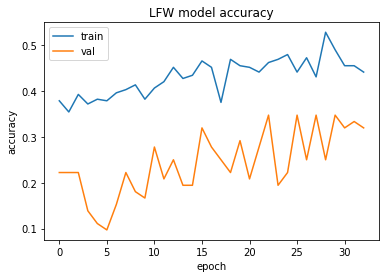

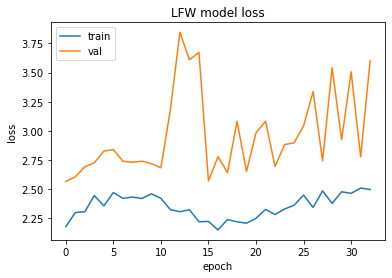

In [ ]:
plt.plot(history_lfw.history['accuracy'])
plt.plot(history_lfw.history['val_accuracy'])
plt.title("LFW model accuracy")
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history_lfw.history['loss'])
plt.plot(history_lfw.history['val_loss'])
plt.title('LFW model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
path = r'/content/drive/MyDrive/Datasets/lwf_archive/lfw_funneled/'

os.chdir(path)

faces = []

with os.scandir(path) as files:
  for file in files:
    name = file.name
    if name.endswith('.txt'):
      continue
    path_2 = os.path.join(path, name)
    os.chdir(path_2)
    with os.scandir(path_2) as files:
      for file2 in files:
        if file2.name.endswith('.jpg'):
          faces.append(file2)


In [ ]:
print(len(faces)) #lfw faces array length
print(faces[:10])

13233
[<DirEntry 'Rod_Paige_0001.jpg'>, <DirEntry 'Rod_Thorn_0001.jpg'>, <DirEntry 'Rodrigo_de_la_Cerna_0001.jpg'>, <DirEntry 'Rod_Jong-il_0001.jpg'>, <DirEntry 'Rogelio_Montemayor_0001.jpg'>, <DirEntry 'Rogelio_Ramos_0001.jpg'>, <DirEntry 'Rogerio_Romero_0001.jpg'>, <DirEntry 'Rogerio_Romero_0002.jpg'>, <DirEntry 'Roger_Clemens_0001.jpg'>, <DirEntry 'Roger_Clemens_0002.jpg'>]


In [17]:
from keras.models import Model
#model_try = Model(inputs = model_lfw.inputs, outputs = model_lfw.layers[-2].output)

def CNN_face(file, model):
  img = load_img(file, target_size = (250, 250))

  img = np.array(img)

  reshaped_image = img.reshape(1, 250, 250, 3)

  imgx = preprocess_input(reshaped_image)

  features = model.predict(imgx, use_multiprocessing=True)

  return features 


In [ ]:
data = {}

for face in faces:
  feat = CNN_face(face, model_try)
  data[face] = feat

filenames = np.array(list(data.keys())) #get filenames

feat = np.array(list(data.values()))

feat = feat.reshape(-1, 128) #get vectors

In [ ]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [ ]:
kmeans_2 = KMeans(n_clusters=5, random_state=22)
kmeans_2.fit(x)

KMeans(n_clusters=5, random_state=22)

In [ ]:
groups_2 = {}

for file, cluster in zip(filenames, kmeans_2.labels_):
  if cluster not in groups_2.keys():
    groups_2[cluster] = []
    groups_2[cluster].append(file)
  else:
    groups_2[cluster].append(file)



In [ ]:
def view_the_cluster(cluster):
  plt.figure(figsize = (25, 25))
  files = groups_2[cluster]
  if len(files) > 30:
    print(f'Dosya sayısı bu sayıdan {len(files)} to 30')
    files = files[:29]

  for index, file in enumerate(files):
    plt.subplot(10, 10, index + 1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.axis('off')


In [ ]:
print(len(groups_2))
for group in range(len(groups_2)):
  view_the_cluster(group)

Output hidden; open in https://colab.research.google.com to view.

Text(0, 0.5, 'Sum of squared distance')

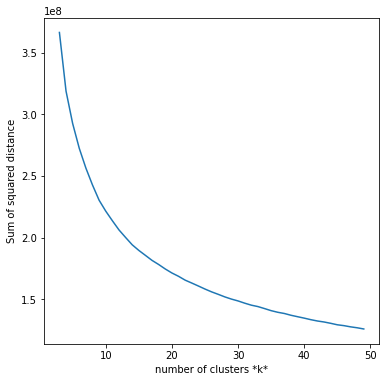

In [ ]:
#which k number is best
sse = []
list_k = list(range(3, 50))

for k in list_k:
  km = KMeans(n_clusters = k, random_state = 22)
  km.fit(x)

  sse.append(km.inertia_)

plt.figure(figsize = (6, 6))
plt.plot(list_k, sse)
plt.xlabel(r"number of clusters *k*")
plt.ylabel("Sum of squared distance")


In [ ]:
#find cluster scores of this model CNN print the scores
#from sklearn.datasets import make_blobs
kmeans_score = KMeans(n_clusters = 5, random_state=22).fit(x)
labels = kmeans_score.labels_
metrics.silhouette_score(x, labels, metric='euclidean') #0.20306759

0.20014805

In [ ]:
kmeans_per_k = [KMeans(n_clusters = k, random_state=22).fit(x) for k in range(3, 50)]

silhouette_score_array = [ metrics.silhouette_score(x, model.labels_, metric='euclidean')
                          for model in kmeans_per_k[1:]]

In [ ]:
#silhouette_score_array

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


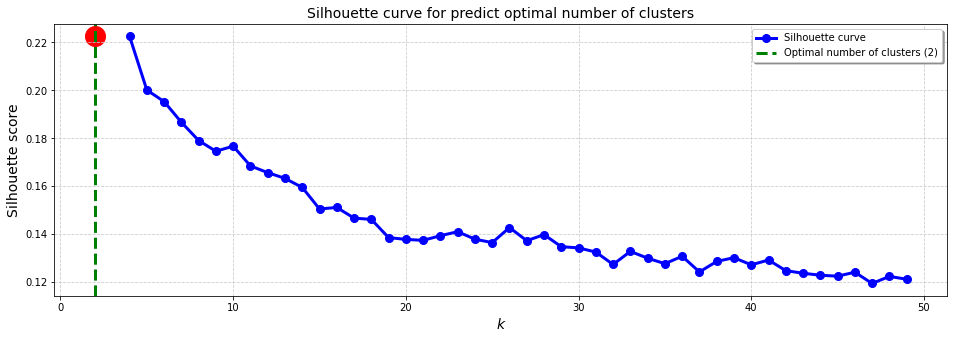

In [ ]:
rcParams['figure.figsize'] = 16, 5
_ = plt.plot(range(4, 50), silhouette_score_array, "bo-", color='blue', linewidth = 3, markersize = 8, label = 'Silhouette curve')
_ = plt.xlabel("$k$", fontsize=14, family = "Arial")
_ = plt.ylabel("Silhouette score", fontsize=14, family = "Arial")
_ = plt.grid(which = "major", color = "#cccccc", linestyle = "--")
_ = plt.title("Silhouette curve for predict optimal number of clusters", family = "Arial", fontsize = 14)

k = np.argmax(silhouette_score_array) + 2

_ = plt.axvline(x = k, linestyle = "--", c = "green", linewidth = 3, label = "Optimal number of clusters ({})".format(k))
_ = plt.scatter(k, silhouette_score_array[k - 2], c = 'red', s = 400)
_ = plt.legend(shadow = True)
_ = plt.show()

In [ ]:
print("The optimal number of cluster for LFW {}.".format(k))

The optimal number of cluster for LFW 2.


In [ ]:
#davies_bouldin_score
kmeans_score = KMeans(n_clusters = 5, random_state = 22).fit(x)
labels = kmeans_score.labels_
metrics.davies_bouldin_score(x, labels) #1.441568

1.449986170897549

In [ ]:
#Calinski-Harabasz Index
kmeans_score = KMeans(n_clusters = 5, random_state = 22).fit(x)
labels = kmeans_score.labels_
metrics.calinski_harabasz_score(x, labels) #3764.8454

3903.078240351547

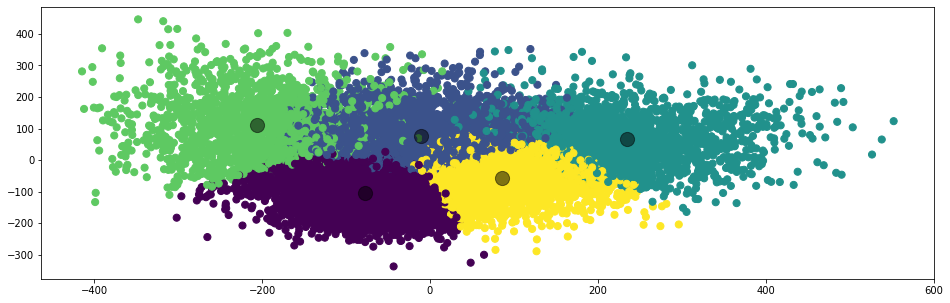

In [ ]:
#visualize clusters 
kmeans_visual = KMeans(n_clusters = 5, random_state = 22).fit(x)
y_kmeans = kmeans_visual.predict(x)

plt.scatter(x[:, 0], x[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans_visual.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);

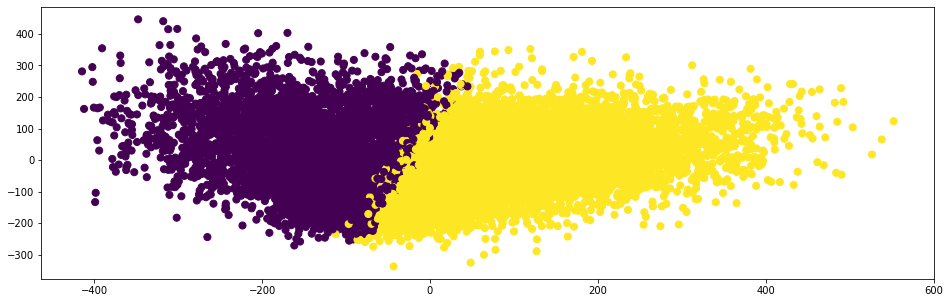

In [ ]:
#make moon 
model_spec = SpectralClustering(n_clusters = 2, affinity = 'nearest_neighbors', assign_labels = 'kmeans')
labels = model_spec.fit_predict(x)
plt.scatter(x[:, 0], x[:, 1], c=labels, s=50, cmap='viridis')

In [ ]:
k = 5
km = KMeans(n_clusters = k, init = 'k-means++', max_iter = 100, n_init = 5, verbose = 1)
km.fit(x)

Initialization complete
Iteration 0, inertia 470705216.0
Iteration 1, inertia 326589568.0
Iteration 2, inertia 306009408.0
Iteration 3, inertia 297748352.0
Iteration 4, inertia 294590560.0
Iteration 5, inertia 293269952.0
Iteration 6, inertia 292825312.0
Iteration 7, inertia 292654848.0
Iteration 8, inertia 292575424.0
Iteration 9, inertia 292524032.0
Iteration 10, inertia 292503552.0
Iteration 11, inertia 292494784.0
Iteration 12, inertia 292490880.0
Iteration 13, inertia 292489920.0
Iteration 14, inertia 292488992.0
Converged at iteration 14: center shift 0.04327556863427162 within tolerance 0.04818966674804688.
Initialization complete
Iteration 0, inertia 408652864.0
Iteration 1, inertia 313711360.0
Iteration 2, inertia 300580544.0
Iteration 3, inertia 295815232.0
Iteration 4, inertia 294257920.0
Iteration 5, inertia 293646592.0
Iteration 6, inertia 293347552.0
Iteration 7, inertia 293153216.0
Iteration 8, inertia 292999072.0
Iteration 9, inertia 292871104.0
Iteration 10, inertia 29

KMeans(max_iter=100, n_clusters=5, n_init=5, verbose=1)

In [ ]:
tfs_reduced = TruncatedSVD(n_components = k, random_state = 0).fit_transform(x)
tfs_embedded = TSNE(n_components = 2, perplexity = 40, verbose = 2).fit_transform(tfs_reduced)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13233 samples in 0.028s...
[t-SNE] Computed neighbors for 13233 samples in 0.760s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13233
[t-SNE] Computed conditional probabilities for sample 2000 / 13233
[t-SNE] Computed conditional probabilities for sample 3000 / 13233
[t-SNE] Computed conditional probabilities for sample 4000 / 13233
[t-SNE] Computed conditional probabilities for sample 5000 / 13233
[t-SNE] Computed conditional probabilities for sample 6000 / 13233
[t-SNE] Computed conditional probabilities for sample 7000 / 13233
[t-SNE] Computed conditional probabilities for sample 8000 / 13233
[t-SNE] Computed conditional probabilities for sample 9000 / 13233
[t-SNE] Computed conditional probabilities for sample 10000 / 13233
[t-SNE] Computed conditional probabilities for sample 11000 / 13233
[t-SNE] Computed conditional probabilities for sample 12000 / 13233
[t-SNE] Computed conditional probabilities for sa

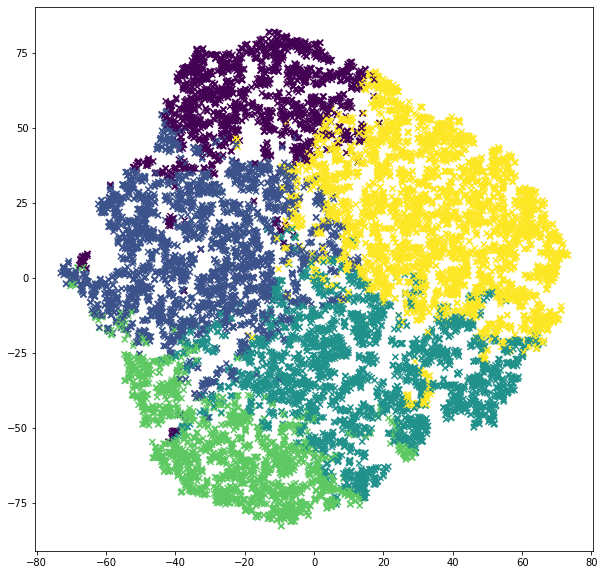

In [ ]:
#t-SNE application
fig = plt.figure(figsize = (10, 10))
ax = plt.axes()
plt.scatter(tfs_embedded[:, 0], tfs_embedded[:, 1], marker = "x", c = km.labels_)
plt.show()

In [ ]:
path = r'/content/drive/MyDrive/Datasets/lwf_archive/lfw_sample/'

faces_3 = []
y_train = []
num = -1 
os.chdir(path)

with os.scandir(path) as files:
  for file in files:
    num += 1
    name = file.name
    if name.endswith('.txt'):
      num -= 1 
      continue
    path_2 = os.path.join(path, name)
    os.chdir(path_2)
    with os.scandir(path_2) as files:
      for file2 in files:
        if file2.name.endswith('.jpg'):
          faces_3.append(file2)
          y_train.append(num)

<class 'posix.DirEntry'>
2728
[<DirEntry 'George_W_Bush_0051.jpg'>, <DirEntry 'George_W_Bush_0027.jpg'>, <DirEntry 'George_W_Bush_0046.jpg'>, <DirEntry 'George_W_Bush_0039.jpg'>, <DirEntry 'George_W_Bush_0009.jpg'>, <DirEntry 'George_W_Bush_0011.jpg'>, <DirEntry 'George_W_Bush_0052.jpg'>, <DirEntry 'George_W_Bush_0008.jpg'>, <DirEntry 'George_W_Bush_0012.jpg'>, <DirEntry 'George_W_Bush_0004.jpg'>]


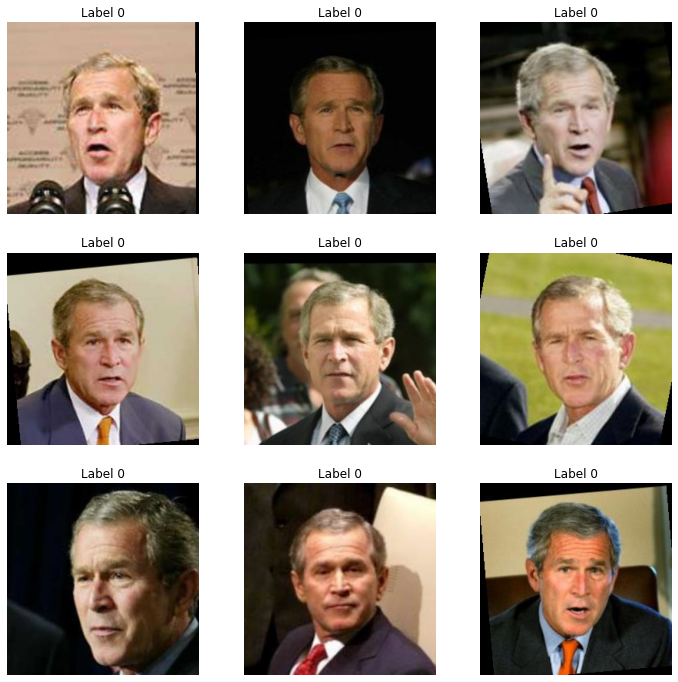

In [ ]:
print(type(faces_3[0]))
print(len(faces_3))
print(faces_3[:10])

fig, axs = plt.subplots(3,3, figsize = (12, 12))

for i, ax in enumerate(axs.flat):
  img = load_img(faces_3[i])
  img = np.array(img)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title('Label {}'.format(y_train[i]))


In [ ]:
print(len(y_train))

2728


In [ ]:
data_3 = {}

for face in faces_3:
  feat = CNN_face(face, model_try)
  data_3[face] = feat

filenames = np.array(list(data_3.keys())) #get the keys
feat = np.array(list(data_3.values()))
feat = feat.reshape(-1, 128)

In [22]:
#define the functions
def infer_cluster_labels(kmeans, actual_labels):
  inferred_labels = {}

  for i in range(kmeans.n_clusters):
    labels = []
    index = np.where(kmeans.labels_ == i)

    labels.append(actual_labels[index])

    if len(labels[0]) == 1:
      counts = np.bincount(labels[0])
    else:
      counts = np.bincount(np.squeeze(labels))

    if np.argmax(counts) in inferred_labels:
      inferred_labels[np.argmax(counts)].append(i)
    else:
      inferred_labels[np.argmax(counts)] = [i]


  return inferred_labels

In [23]:
def infer_data_labels(X_labels, cluster_labels):
  predicted_labels = np.zeros(len(X_labels)).astype(np.uint8)

  for i, cluster in enumerate(X_labels):
    for key, value in cluster_labels.items():
      if cluster in value:
        predicted_labels[i] = key

  return predicted_labels

In [24]:
from sklearn.metrics import homogeneity_score

def calc_metrics(estimator, labels):
  print('Number of clusters: {}'.format(estimator.n_clusters))

  inertia = estimator.inertia_
  print('Inertia: {}'.format(inertia))

  homogenity = homogeneity_score(labels, estimator.labels_)
  print('Homogenity score: {}'.format(homogenity))

In [ ]:
pca = PCA(n_components=100, random_state=22)
pca_3 = pca.fit(feat)
x = pca_3.transform(feat)

In [ ]:
#kmeans
kmeans = KMeans(n_clusters=6, random_state=22)
kmeans.fit(x)

KMeans(n_clusters=6, random_state=22)

In [ ]:
y_train = np.array(y_train)
print(y_train.shape)
cluster_labels = infer_cluster_labels(kmeans, y_train)

(2728,)


In [ ]:
X_clusters = kmeans.predict(x) #predict the labels
predicted_labels = infer_data_labels(kmeans.labels_, cluster_labels)
print(predicted_labels[:20])
print(y_train[:20])
print(predicted_labels.shape)

[0 3 4 0 4 0 4 3 1 3 0 4 3 3 0 4 4 0 1 4]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(2728,)


In [ ]:
from sklearn.metrics import accuracy_score
calc_metrics(kmeans, y_train)
acc = accuracy_score(y_train, predicted_labels)
print('Accuracy: {}\n'.format(acc)) #accuracy rate

Number of clusters: 6
Inertia: 842631.6875
Homogenity score: 0.012886788689260853
Accuracy: 0.21151026392961877



In [ ]:
#group 2 version
path = r'/content/drive/MyDrive/Datasets/lwf_archive/lfw_sample2/'
num = -1

os.chdir(path)
faces_3 = []
y_train3 = []

with os.scandir(path) as files:
  for file in files:
    num += 1
    name = file.name
    if name.endswith('.txt'):
      num -= 1
      continue
    path_2 = os.path.join(path, name)
    os.chdir(path_2)
    with os.scandir(path_2) as files:
      for file2 in files:
        if file2.name.endswith('.jpg'):
          faces_3.append(file2)
          y_train3.append(num) 



<class 'posix.DirEntry'>
850
[<DirEntry 'Adriana_Perez_Navarro_0001.jpg'>, <DirEntry 'Agnes_Bruckner_0001.jpg'>, <DirEntry 'Adrianna_Zuzic_0001.jpg'>, <DirEntry 'Afton_Smith_0001.jpg'>, <DirEntry 'Adriana_Lima_0001.jpg'>, <DirEntry 'Alanis_Morissette_0001.jpg'>, <DirEntry 'Aileen_Riggin_Soule_0001.jpg'>, <DirEntry 'Aishwarya_Rai_0001.jpg'>, <DirEntry 'Aiysha_Smith_0001.jpg'>, <DirEntry 'Alberta_Lee_0001.jpg'>]


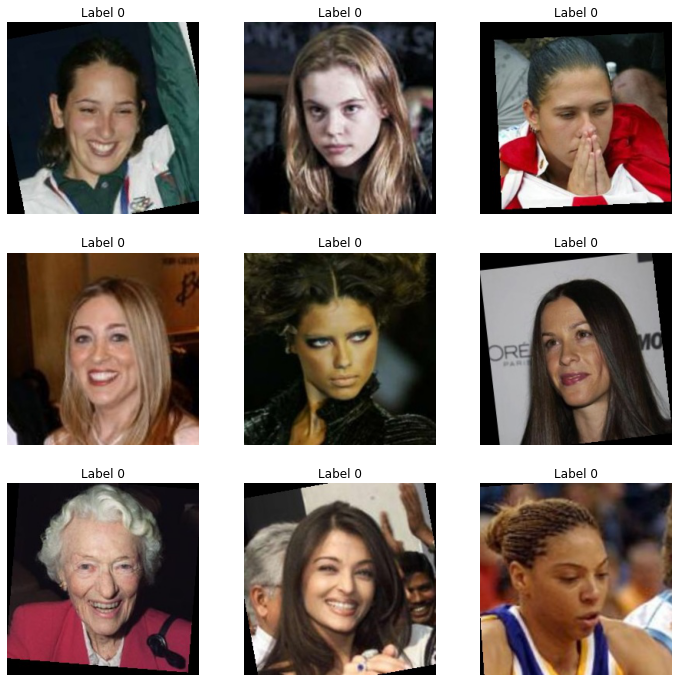

In [ ]:
print(type(faces_3[0]))
print(len(faces_3))
print(faces_3[:10])

fig, axs = plt.subplots(3, 3, figsize = (12, 12))
for i, ax in enumerate(axs.flat):
  img = load_img(faces_3[i])
  img = np.array(img)
  ax.imshow(img)
  ax.axis('off')
  ax.set_title('Label {}'.format(y_train3[i]))

In [ ]:
data_4 = {}

for face in faces_3:
  feat = CNN_face(face, model_try)
  data_4[face] = feat

filenames = np.array(list(data_4.keys()))
feat = np.array(list(data_4.values()))
feat = feat.reshape(-1, 128)

In [ ]:
pca = PCA(n_components=100, random_state=22)
pca.fit(feat)
x = pca.transform(feat)

In [ ]:
kmeans = KMeans(n_clusters=2, random_state = 22)
kmeans.fit(x)

KMeans(n_clusters=2, random_state=22)

In [ ]:
groups_2 = {}
for file, cluster in zip(filenames, kmeans.labels_):
  if cluster not in groups_2.keys():
    groups_2[cluster] = []
    groups_2[cluster].append(file)
  else:
    groups_2[cluster].append(file)

2
Dosya sayısı bu sayıdan 466 to 30
Dosya sayısı bu sayıdan 384 to 30


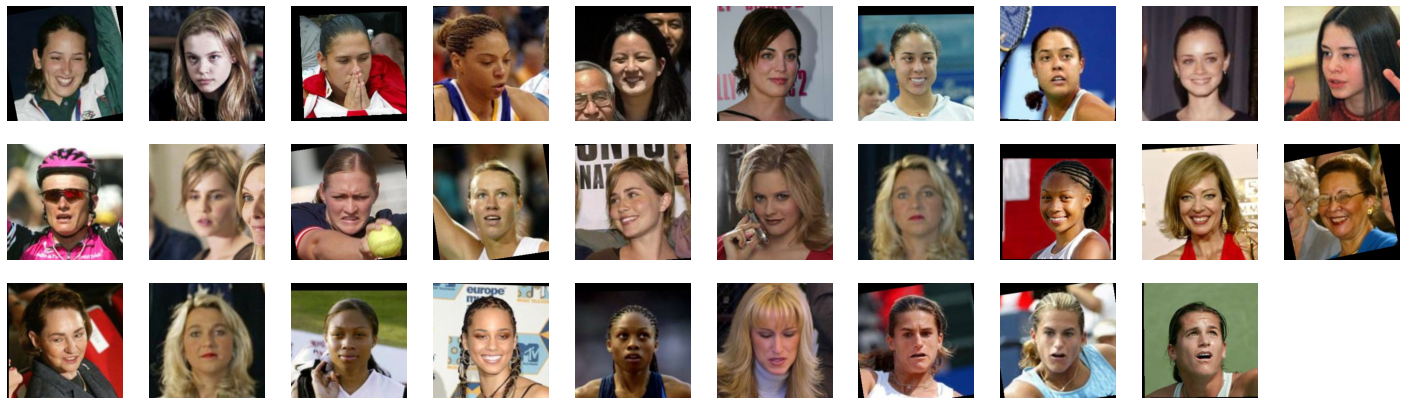

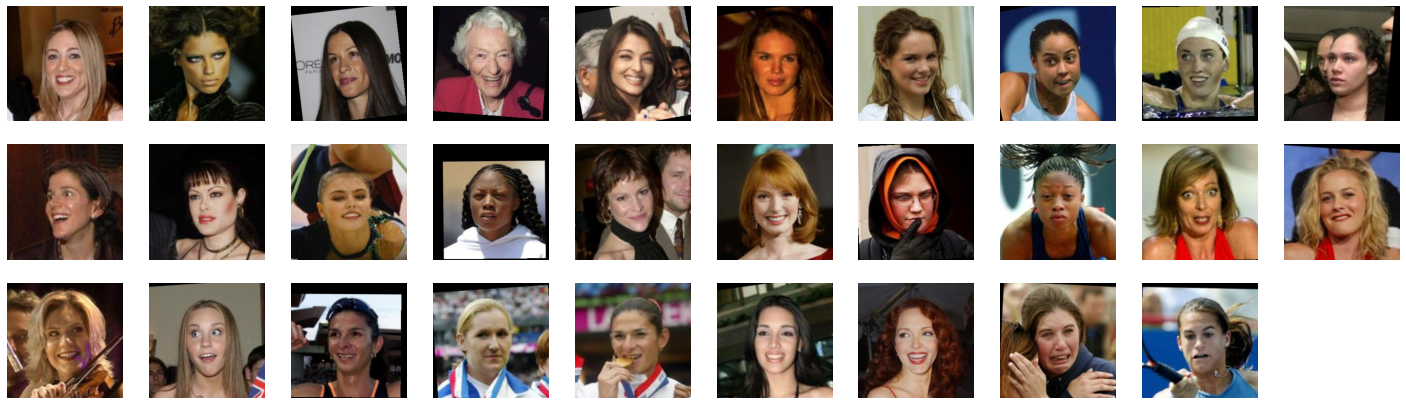

In [ ]:
print(len(groups))
for group in range(len(groups)):
  view_the_cluster(group)


In [ ]:
y_array3 = np.array(y_train3)
cluster_labels = infer_cluster_labels(kmeans, y_array3)
print(y_array3.shape)

(850,)


In [ ]:
X_clusters = kmeans.predict(x)
predicted_labels = infer_data_labels(kmeans.labels_, cluster_labels)
print(predicted_labels[:20])
print(y_array3[:20])
print(predicted_labels.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(850,)


In [ ]:
from sklearn.metrics import accuracy_score
calc_metrics(kmeans, y_array3)
acc = accuracy_score(y_array3, predicted_labels)
print('Accuracy: {}\n'.format(acc))

Number of clusters: 2
Inertia: 461525.46875
Homogenity score: 0.0009637087576259146
Accuracy: 0.5294117647058824



In [25]:
#basit yapılı CNN 6 gizli filtreli (model den içeren kısım çalıştırılmalı)
y_array_d = np.array(y_train)
cluster_labels = infer_cluster_labels(kmeans_den, y_array_d) 
print(y_array_d.shape)

(850,)


In [26]:
predicted_labels = infer_data_labels(kmeans_den.labels_, cluster_labels)  
print(predicted_labels[:20]) 
print(y_array_d[:20])
print(predicted_labels.shape)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
(850,)


In [27]:
from sklearn.metrics import accuracy_score
calc_metrics(kmeans_den, y_array_d) 
acc = accuracy_score(y_array_d, predicted_labels) 
print('Accuracy: {}\n'.format(acc))

Number of clusters: 2
Inertia: 390111296.0
Homogenity score: 0.0018329572140321664
Accuracy: 0.5294117647058824

